In [1]:
# importing packages !
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize
import scipy.linalg as linalg

from obspy.clients.syngine import Client
client = Client()

#from pyTransC import TransC_Sampler

import arviz as az

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg

from obspy.signal.rotate import rotate_ne_rt
from StationNoiseSampling import *
from TransCFunctionsAlex import *

#from pyTransC import TransC_Sampler

import obspy
import pandas as pd
from datetime import datetime
from obspy.geodetics import gps2dist_azimuth
from obspy import Stream
#import UTCDateTime

from obspy.clients.fdsn import Client
ap = Client('IRIS')
from scipy.optimize import minimize

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

# setting global parameter controls
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling
autopseudo = True    # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False     # Thin internally generated within state posterior ensembles by their auto-correlation 
                     # (This can take additional compute time, and is not necessary if input ensembles are already independent.)


In [2]:
def sqExp(x1, x2, s1, rho):
    """
    Squared Exponential Covariance Function.
    This function calculates the covariance between two points.

    Args:
        x1 (float or np.ndarray): The first time point(s).
        x2 (float or np.ndarray): The second time point(s).
        s1 (float): The noise standard deviation parameter.
        rho (float): The noise correlation length parameter.

    Returns:
        float or np.ndarray: The calculated covariance.
    """
    return (s1**2) * np.exp(-(x1 - x2)**2 / (2.0 * rho**2))

def build_covariance_matrix(time, s1, rho):
    """
    Builds the covariance matrix C from the time vector and noise parameters.

    Args:
        times (np.ndarray): A 1D NumPy array of time values.
        s1 (float): The noise standard deviation parameter.
        rho (float): The noise correlation length parameter.

    Returns:
        np.ndarray: The n x n covariance matrix.
    """
    n = len(time)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            C[i, j] = sqExp(time[i], time[j], s1, rho)
    # Add a small value to the diagonal for numerical stability (known as "nugget")
    C += np.eye(n) * 1e-6
    return C

def log_likelihood_res(params, residuals, times):
    """
    The negative log-likelihood function to be minimized.
    We minimize the negative log-likelihood because optimizers are designed for minimization.

    Args:
        params (list or np.ndarray): A list containing [s1, rho].
        residuals (np.ndarray): A 1D NumPy array of residuals (d - dp).
        times (np.ndarray): A 1D NumPy array of time values.

    Returns:
        float: The negative log-likelihood value.
    """
    s1, rho = params

    if s1 <= 0 or rho <= 0:
        return np.inf  # Return a large value if parameters are non-physical

    try:
        C = build_covariance_matrix(times, s1, rho)
        C_inv = linalg.inv(C)
        det_C = linalg.det(C)
        
        # Check for non-positive definite matrix
        if det_C <= 0:
            return np.inf

        n = len(residuals)
        
        # The log-likelihood equation
        logL = -0.5 * (n * np.log(2 * np.pi) + np.log(det_C) + residuals.T @ C_inv @ residuals)
        
        return -logL  # Return the negative log-likelihood
        
    except np.linalg.LinAlgError:
        # Handle cases where the matrix is singular or not positive definite
        return np.inf


def estimate_noise_parameters(residuals, times, s1_initial, rho_initial):
    """
    Estimates the noise parameters s1 and rho by maximizing the log-likelihood
    of the residuals.

    Args:
        residuals (np.ndarray): A 1D NumPy array of residuals (d - dp) from a best-fit model.
        times (np.ndarray): A 1D NumPy array of time values corresponding to the residuals.
        s1_initial (float): An initial guess for the s1 parameter.
        rho_initial (float): An initial guess for the rho parameter.

    Returns:
        dict: A dictionary containing the estimated s1, rho, and the final likelihood value.
    """
    initial_guess = [s1_initial, rho_initial]

    # Use a numerical optimizer to find the parameters that minimize the negative log-likelihood
    result = minimize(
        fun=log_likelihood_res,
        x0=initial_guess,
        args=(residuals, times),
        method='L-BFGS-B',  # A good choice for this type of problem
        bounds=[(1e-6, None), (1e-6, None)] # Ensure s1 and rho are positive
    )
    
    if result.success:
        s1_est, rho_est = result.x
        # The log-likelihood is the negative of the minimized function value
        logL_value = -result.fun
        return {
            "s1": s1_est,
            "rho": rho_est,
            "log_likelihood": logL_value,
            "success": True,
            "message": "Optimization successful."
        }
    else:
        return {
            "s1": None,
            "rho": None,
            "log_likelihood": None,
            "success": False,
            "message": f"Optimization failed: {result.message}"
        }

In [3]:
# setting up the station inventory for UNGL
inv = ap.get_stations(network='*', station="UNGL", level='response', channel='LHZ,LHN,LHE', starttime=obspy.UTCDateTime(2016,1,1,1),
                      endtime = obspy.UTCDateTime(2020,1,1,1), maxlatitude=-63)
print(inv)

sta_lats = []
sta_lons = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        sta_lats.append(inv[i][j].latitude)
        sta_lons.append(inv[i][j].longitude)

print('Number of stations:', len(sta_lats))

# indexing the stations to a single variable

stations_flat = []
networks_flat = []
for i in range(len(inv)):
    for j in range(len(inv[i])):
        stations_flat.append(inv[i][j].code)
        networks_flat.append(inv[i].code)

print((stations_flat))
print(len(networks_flat))

bulk_stations = []

for i in range(len(sta_lats)):
    receiver_lat = sta_lats[i]
    receiver_lon = sta_lons[i]
    station_code = stations_flat[i]
    bulk_stations.append({"latitude": receiver_lat, "longitude": receiver_lon, "stationcode": station_code})

#print(bulk_stations)

Inventory created at 2025-10-15T23:09:23.587300Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (1):
			YT.UNGL (Union Glacier)
		Channels (6):
			YT.UNGL..LHZ (2x), YT.UNGL..LHN (2x), YT.UNGL..LHE (2x)
Number of stations: 1
['UNGL']
1


In [4]:
# importing Son's events

son = pd.read_csv(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\Pham2025_submitted\TableS1.csv")
#son = pd.read_csv(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\Pham2025_submitted\TableS1.csv")
#son = son[son['quality_group'] == 'A'] # filtering to only the quality A events

lats = son['relocated_latitude'].tolist()
lons = son['relocated_longitude'].tolist()

det_lats = son['detected_latitude'].tolist()
det_lons = son['detected_longitude'].tolist()

mags = son['Ms_BB'].tolist()
times = son['relocated_time'].tolist()
qual_group = son['quality_group'].tolist()
ens = son['eff_nstations'].tolist()

#qualities = son['quality_group'].tolist()

son_date_format = '%Y-%m-%dT%H:%M:%S.000000Z'

years = []
months = []
days = []
for i in range(len(times)):
    years.append(int(datetime.strptime(times[i], son_date_format).strftime('%Y')))
    months.append(int(datetime.strptime(times[i], son_date_format).strftime('%m')))
    days.append(int(datetime.strptime(times[i], son_date_format).strftime('%d')))
    
# calculate the distance between two stations
def distance(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[0]

def back_azimuth(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[2]

# isolating the specific event
test = []

for i in range(len(times)):
    if times[i] == '2018-11-08T05:03:34.000000Z':
        test.append(i)
        event_lat = lats[i]
        event_lon = lons[i]
        event_time = times[i]
        event_mag = mags[i]
        event_year = years[i] + months[i]/12 + days[i]/365
        
#

In [5]:
event_info = event_lat, event_lon, event_time

station_infos = []

for i in range(len(sta_lats)):
    station_info = inv, networks_flat[i], stations_flat[i], sta_lats[i], sta_lons[i]
    station_infos.append(station_info)
    
station_inf = [sta_lats, sta_lons, networks_flat, stations_flat]

In [6]:
# downloading the initial signals 

real_signals, dist_infos, back_azs, begin_times, end_times, arrival_times = acquire_real_waveforms(station_inf, event_info, inv)

real_signals

3 Trace(s) in Stream:
YT.UNGL..LHE | 2018-11-08T05:01:10.999998Z - 2018-11-08T05:14:29.999998Z | 1.0 Hz, 800 samples
YT.UNGL..LHN | 2018-11-08T05:01:10.999998Z - 2018-11-08T05:14:29.999998Z | 1.0 Hz, 800 samples
YT.UNGL..LHZ | 2018-11-08T05:01:10.999998Z - 2018-11-08T05:14:29.999998Z | 1.0 Hz, 800 samples

In [7]:
p_real_signals, npts, delta = preprocessing_real_waveforms(real_signals)

for tr in p_real_signals:
    tr.trim(starttime=tr.stats.starttime, endtime=tr.stats.endtime - 1)
    
p_real_signals

3 Trace(s) in Stream:
YT.UNGL..LHT | 2018-11-08T05:05:19.999998Z - 2018-11-08T05:09:28.999998Z | 1.0 Hz, 250 samples
YT.UNGL..LHR | 2018-11-08T05:05:19.999998Z - 2018-11-08T05:09:28.999998Z | 1.0 Hz, 250 samples
YT.UNGL..LHZ | 2018-11-08T05:05:19.999998Z - 2018-11-08T05:09:28.999998Z | 1.0 Hz, 250 samples

In [8]:
ydatas, real_station_streams = setup_ydata(p_real_signals)
real_station_streams

[3 Trace(s) in Stream:
YT.UNGL..LHZ | 2018-11-08T05:05:19.999998Z - 2018-11-08T05:09:28.999998Z | 1.0 Hz, 250 samples
YT.UNGL..LHR | 2018-11-08T05:05:19.999998Z - 2018-11-08T05:09:28.999998Z | 1.0 Hz, 250 samples
YT.UNGL..LHT | 2018-11-08T05:05:19.999998Z - 2018-11-08T05:09:28.999998Z | 1.0 Hz, 250 samples]

In [9]:
# setting up the scaling factors for the elementary functions 
scaling_SF = np.array([1E9, 1E9, 1E8]) # Fr, Ft, Fp << matched from Son's for order of mag 
scaling_MT = np.array([1E13, 1E13, 1E13, 1E15, 1E15, 1E13]) # Mrr, Mtt, Mpp, Mrt, Mrp, Mtp << like 4 orders of magnitude larger

In [10]:
# finding the earliest and latest times to be gathering from
earliest_time = min(begin_times)
latest_time = max(end_times)

ttot = latest_time-earliest_time

starter_time = obspy.UTCDateTime(event_time) - earliest_time

# Using list comprehension - each arrival time repeated 3 times
arrival_times_expanded = [arrival_time for arrival_time in arrival_times for _ in range(3)]

coche = client.get_model_info(model_name='prem_a_10s')

time_info = [starter_time, ttot, arrival_times_expanded]

stations = [station['stationcode'] for station in bulk_stations]
stations

['UNGL']

In [11]:
def SF_elementary_func(set):
    data = client.get_waveforms_bulk(
        model = 'prem_a_10s',
        bulk = bulk_stations,
        sourcelatitude = event_lat,
        sourcelongitude = event_lon,
        sourcedepthinmeters = 500,  # 500 m depth
        sourceforce = set*scaling_SF, # single force event - Fr, Ft, Fp
        origintime = obspy.UTCDateTime(event_time),
        starttime = -starter_time,
        endtime = ttot, 
        components = 'ZRT',
        units = 'displacement'
    )
    
    conv_data = convolution_function(data)
    
    conv_data.resample(1.0)

    for tr in conv_data:
        # correct for sign flip in the radial component
        if tr.stats.channel.endswith('R'): tr.data *= -1

    conv_data.detrend('demean')
    conv_data.detrend('linear')
    conv_data.taper(max_percentage=0.1)
    
    for i in range(len(conv_data)):
        conv_data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 3, zerophase = True) # ok looks like this happens post conv.
        conv_data[i].trim(starttime=arrival_times_expanded[i]-150, endtime=arrival_times_expanded[i]+100)
        conv_data[i].taper(max_percentage=0.15)
        #data[i].trim(starttime=data[i].stats.starttime + 200, endtime=data[i].stats.endtime - 200)
        
        # Ensure exactly 250 samples
        if len(conv_data[i].data) > 250:
            # Trim to first 250 samples
            conv_data[i].data = conv_data[i].data[:250]
            conv_data[i].stats.npts = 250
        elif len(conv_data[i].data) < 250:
            # Pad with zeros to reach 250 samples
            padding = np.zeros(250 - len(conv_data[i].data))
            conv_data[i].data = np.concatenate([conv_data[i].data, padding])
            conv_data[i].stats.npts = 250

        # # Update endtime to match new length
        # data[i].stats.endtime = data[i].stats.starttime + (399 / data[i].stats.sampling_rate)
    
    station_streems = []
    outputs = []
    # Fix: Extract station codes from trace stats, not the traces themselves
    for station in stations:
        station_streem = conv_data.select(station=station)
        if len(station_streem) == 3:
            station_streem = station_streem.select(component='Z') + \
                        station_streem.select(component='R') + \
                        station_streem.select(component='T')
            station_streems.append(station_streem)

            ydota = [station_streem[0].data, station_streem[1].data, station_streem[2].data]            
            outputs.append(ydota)

    return outputs

SF_e1 = SF_elementary_func(np.array([1, 0, 0])) # Fr
SF_e2 = SF_elementary_func(np.array([0, 1, 0])) # Ft
SF_e3 = SF_elementary_func(np.array([0, 0, 1])) # Fp

In [12]:
def MT_elementary_func(set):
    data = client.get_waveforms_bulk(
        model = 'prem_a_10s',
        bulk = bulk_stations,
        sourcelatitude = event_lat,
        sourcelongitude = event_lon,
        sourcedepthinmeters = 500,  # 500 m depth
        sourcemomenttensor = set*scaling_MT, # single force event - Mrr, Mtt, Mpp, Mrt, Mrp, Mtp
        origintime = obspy.UTCDateTime(event_time),
        starttime = -starter_time,
        endtime = ttot, 
        components = 'ZRT',
        units = 'displacement'
    )
    data.resample(1.0)
    data.detrend('demean')
    data.detrend('linear')
    data.taper(max_percentage=0.1)
    
    for i in range(len(data)): # no convolution required for MT sources apparently
        data[i].trim(starttime=arrival_times_expanded[i]-350, endtime=arrival_times_expanded[i]+300)
        data[i].filter('bandpass', freqmin = 0.04, freqmax = 0.06, corners = 3, zerophase = True)
        data[i].trim(starttime=data[i].stats.starttime + 200, endtime=data[i].stats.endtime - 200)
        data[i].taper(max_percentage=0.15)
        
        # Ensure exactly 250 samples
        if len(data[i].data) > 250:
            # Trim to first 250 samples
            data[i].data = data[i].data[:250]
            data[i].stats.npts = 250
        elif len(data[i].data) < 250:
            # Pad with zeros to reach 250 samples
            padding = np.zeros(250 - len(data[i].data))
            data[i].data = np.concatenate([data[i].data, padding])
            data[i].stats.npts = 250

        # # Update endtime to match new length
        # data[i].stats.endtime = data[i].stats.starttime + (399 / data[i].stats.sampling_rate)
    
    station_streems = []
    outputs = []
    # Fix: Extract station codes from trace stats, not the traces themselves
    for station in stations:
        station_streem = data.select(station=station)
        if len(station_streem) == 3:
            station_streem = station_streem.select(component='Z') + \
                        station_streem.select(component='R') + \
                        station_streem.select(component='T')
            station_streems.append(station_streem)

            ydota = [station_streem[0].data, station_streem[1].data, station_streem[2].data]            
            outputs.append(ydota)

    return outputs

MT_e1 = MT_elementary_func(np.array([1, 0, 0, 0, 0, 0])) # Mrr
MT_e2 = MT_elementary_func(np.array([0, 1, 0, 0, 0, 0])) # Mtt
MT_e3 = MT_elementary_func(np.array([0, 0, 1, 0, 0, 0])) # Mpp
MT_e4 = MT_elementary_func(np.array([0, 0, 0, 1, 0, 0])) # Mrt
MT_e5 = MT_elementary_func(np.array([0, 0, 0, 0, 1, 0])) # Mrp
MT_e6 = MT_elementary_func(np.array([0, 0, 0, 0, 0, 1])) # Mtp

In [13]:
import pickle

with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\Syngine\TransCSepOct\stage2 - Copy\cdinv_real_singlestation.pkl", "rb") as f:
    cdinv_real = pickle.load(f)
    
with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\Syngine\TransCSepOct\stage2 - Copy\cdsets_real_singlestation.pkl", "rb") as f:
    cdsets_real = pickle.load(f)
    
print(len(cdinv_real))
print(len(cdinv_real[0]))
print(len(cdinv_real[0][0]))
print(len(cdinv_real[0][0][0]))

1
2
3
250


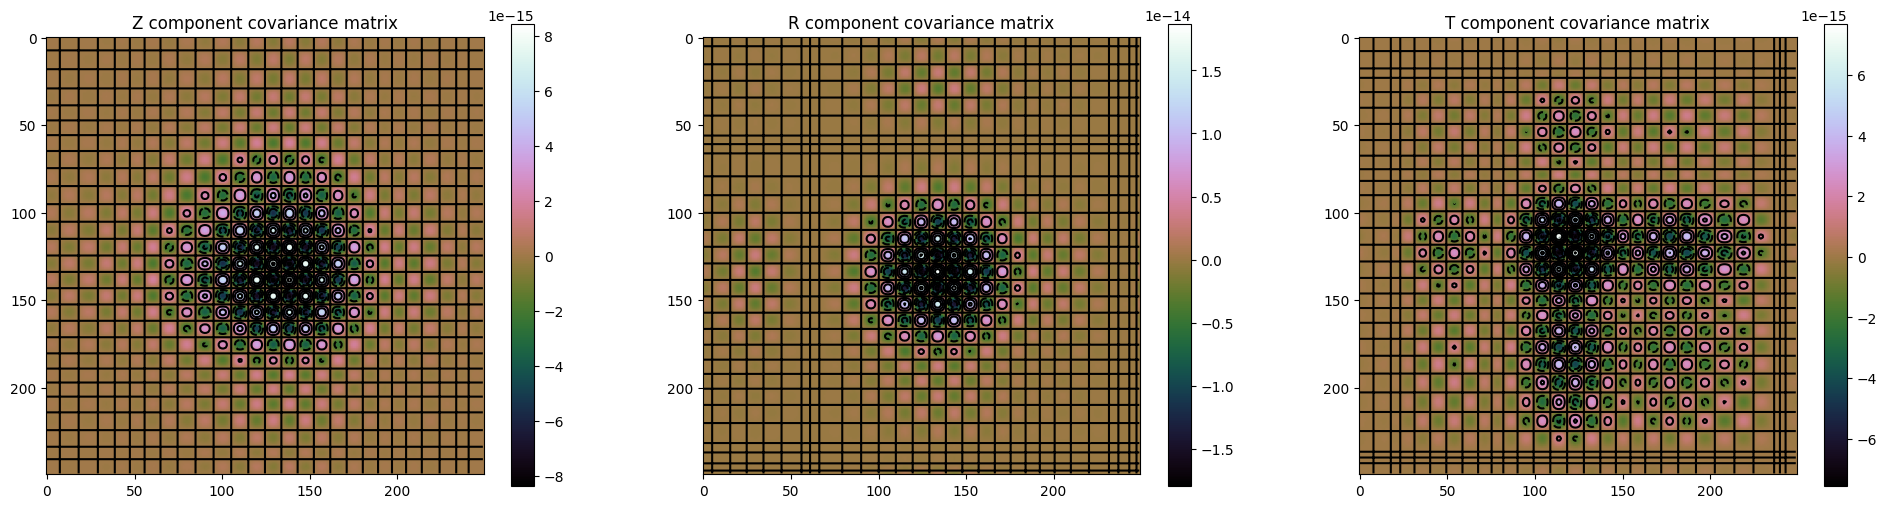

In [14]:
## showing the Covariance matrices
import numpy as np
import matplotlib.pyplot as plt

# C_ddz = np.linalg.inv(cdinv_real[0][0][0])
# C_ddr = np.linalg.inv(cdinv_real[0][0][1])
# C_ddt = np.linalg.inv(cdinv_real[0][0][2])

C_ddz = cdsets_real[0][0][0]
C_ddr = cdsets_real[0][0][1]
C_ddt = cdsets_real[0][0][2]

Cd_set = [C_ddz, C_ddr, C_ddt]

fig = plt.figure(figsize=(24, 6))
axes = []

ax_z = plt.subplot(1, 3, 1)
axes.append(ax_z)
Zplot = ax_z.imshow(C_ddz, cmap=plt.cm.cubehelix)
plt.colorbar(Zplot, ax=ax_z)
ax_z.contour(C_ddz, 10, colors='k')
ax_z.set_title('Z component covariance matrix')

ax_r = plt.subplot(1, 3, 2, sharey=ax_z)
axes.append(ax_r)
Rplot = ax_r.imshow(C_ddr, cmap=plt.cm.cubehelix)
plt.colorbar(Rplot, ax=ax_r)
ax_r.contour(C_ddr, 10, colors='k')
ax_r.set_title('R component covariance matrix')

ax_t = plt.subplot(1, 3, 3, sharey=ax_z)
axes.append(ax_t)
Tplot = ax_t.imshow(C_ddt, cmap=plt.cm.cubehelix)
plt.colorbar(Tplot, ax=ax_t)
ax_t.contour(C_ddt, 10, colors='k')
ax_t.set_title('T component covariance matrix')

plt.show()

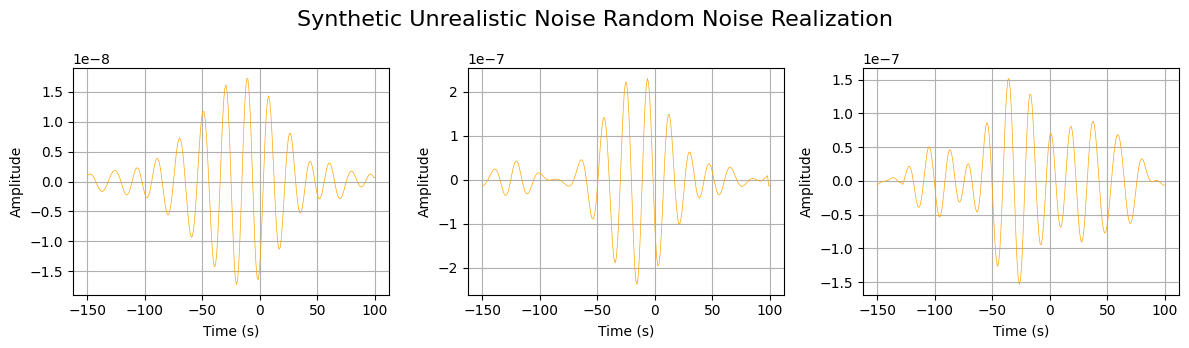

In [15]:
if(True):
    # Now plot the input noise signals with a realization from the estimated Gaussian to see if they fit
    tt = np.linspace(-150, 100, 250)  # Assuming 250 samples at 1 Hz sampling rate
    fig_height = 3.5  # Adjust scaling as needed
    fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharex=True)
    noise_stat,noise_realization = 0,6
    # noise = [low_amps_z,low_amps_r,low_amps_t]
    #cdn = [cd_z,cd_r,cd_t]
    # res = [res_z,res_r,res_t]
    for i in range(1):
        for j, comp in enumerate(['Z', 'R', 'T']):
            ax = axes[j]
            #ax.plot(time, ydatas[0][:, j], c='k', label=f'{stations[i]} {comp}')
            #ax.plot(time, ydatas[0][:, j]-res[j][0], c='r', label='SF Son et al. 2025')
            # ax.plot(time,res[j][0],c='k',lw=0.5)
            ax.plot(tt,np.random.multivariate_normal(np.zeros(250),Cd_set[j]),c='orange',lw=0.5)
            ax.set_ylabel(f'Amplitude')
            ax.set_xlabel('Time (s)')
            ax.grid(True)
            #ax.legend(loc='upper right', fontsize=8)
    plt.suptitle('Synthetic Unrealistic Noise Random Noise Realization', fontsize=16)
    plt.tight_layout()
    plt.show()    

In [16]:
## adding a small value to the data to account for numerical stability
# This is a common practice to avoid singular matrices in numerical computations.


# finding Cdinv_z, r, and t

Cddinv_z = cdinv_real[0][0][0]
Cddinv_r = cdinv_real[0][0][1]
Cddinv_t = cdinv_real[0][0][2]

# Cddinv_z = np.linalg.inv(cdsets_real[0][0][0] + np.eye(250)*1E-16)
# Cddinv_r = np.linalg.inv(cdsets_real[0][0][1] + np.eye(250)*1E-16)
# Cddinv_t = np.linalg.inv(cdsets_real[0][0][2] + np.eye(250)*1E-16)

## finding the log of the determinants of the covariance matrices
# log(sqrt(det(C^-1))) = -1/2 sum(log(lambda_i)) for lambda being the eigenvalues of C

C_ddz_sum, C_ddr_sum, C_ddt_sum = 0, 0, 0
for i in range(len(np.linalg.eig(C_ddz)[0])):
    C_ddz_sum += np.log(np.linalg.eig(C_ddz)[0][i])
for i in range(len(np.linalg.eig(C_ddr)[0])):
    C_ddr_sum += np.log(np.linalg.eig(C_ddr)[0][i])
for i in range(len(np.linalg.eig(C_ddt)[0])):
    C_ddt_sum += np.log(np.linalg.eig(C_ddt)[0][i])

print("C_ddz_sum:", C_ddz_sum)
print("C_ddr_sum:", C_ddr_sum)
print("C_ddt_sum:", C_ddt_sum)

Cddinv_z_logdet = 0.5*(-C_ddz_sum).real # this is all real, but this helps it format the values properly
Cddinv_r_logdet = 0.5*(-C_ddr_sum).real
Cddinv_t_logdet = 0.5*(-C_ddt_sum).real

print("c_ddz_inv_det:", Cddinv_z_logdet)
print("c_ddr_inv_det:", Cddinv_r_logdet)
print("c_ddt_inv_det:", Cddinv_t_logdet)

C_ddz_sum: (-17489.832103037377+37.69911184307753j)
C_ddr_sum: (-17594.63036687402+47.12388980384691j)
C_ddt_sum: (-17533.11878059024+47.12388980384692j)
c_ddz_inv_det: 8744.916051518689
c_ddr_inv_det: 8797.31518343701
c_ddt_inv_det: 8766.55939029512


In [17]:
# G matrices
Glist_SF = []
for i in range(len(stations)):
    GSF = np.transpose([SF_e1[i], SF_e2[i], SF_e3[i]])
    Glist_SF.append(GSF) # list of G matrices for each state
    
Glist_MT = []
for i in range(len(stations)):
    GMT = np.transpose([MT_e1[i], MT_e2[i], MT_e3[i], MT_e4[i], MT_e5[i], MT_e6[i]])
    Glist_MT.append(GMT) # list of G matrices for each state

In [18]:
# defining the dimensional space of the thing
nstates = 2
ndims_SF = 3
ndims_MT = 6
sigma = 50 # weaker prior model covariance << this has made the prior much stronger

# prior PDF parameters (approximate expected parameter values)
mu_SF = [-3, 2, 6] # << more or less taken fron Son's -2.747817857774633 1.7271417083824983 6.147906282830952
mu_MT = [25, -25, -20, 10, -3, -40] # << a guess 26.978422827945437 -25.430668819981314 -15.52056466383073 13.11266483895689 -2.9515670217858716 -41.58499996697125

# covariance / data covariance matrices
cov_SF =   np.eye(ndims_SF) * sigma**2 # prior model covariance matrices for each state
cov_dets_SF =   np.linalg.det(cov_SF)   # determinants of covariance matrices
cov_MT =   np.eye(ndims_MT) * sigma**2 # prior model covariance matrices for each state
cov_dets_MT =   np.linalg.det(cov_MT)   # determinants of covariance matrices

Cdinv_set = [[Cddinv_z, Cddinv_r, Cddinv_t]]  # inverse data covariance matrices for each state << have one of these per station
cdinv = [Cdinv_set[0]]

logdet_set = [[None, None, None]]
log_cdinv_dets = [[logdet_set[0], logdet_set[0]]]

In [19]:
# setting up the log prior function
def log_prior_SF(model):
    '''
    Normalised normal distribution prior for the parameters of the source model.
    '''
    mean = mu_SF
    covar = cov_SF
    covar_det = cov_dets_SF
    r = mean - model

    log_const = - 0.5*len(model)*np.log(2*np.pi) - 0.5*np.log(covar_det) 
    out = log_const-0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out 

#

def log_prior_MT(model):
    '''
    Normalised normal distribution prior for the parameters of the source model.
    '''
    mean = mu_MT
    covar = cov_MT
    covar_det = cov_dets_MT
    r = mean - model

    log_const = - 0.5*len(model)*np.log(2*np.pi) - 0.5*np.log(covar_det) 
    out = log_const-0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out 

#

In [20]:
# setting up the log likelihood function
def log_likelihood_SF(model, align=True, verbose=False,returnlikes=False):
    '''
    Gaussian log likelihood function - requires you to input the "G matrix" for each state you want to test
    y is the data going in
    '''
    
    ll_z_sum, ll_n_sum, ll_e_sum = 0, 0, 0
    ll_zs,ll_ns,ll_es = [],[],[]
    
    for i in range(len(stations)):
        G = Glist_SF[i]
        Cdinv_z, Cdinv_n, Cdinv_e = cdinv[i]
        # Cdinv_det_z, Cdinv_det_n, Cdinv_det_e = cdinv_dets[i]
        data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
        model_z, model_r, model_t = np.dot(G[:,0], model), np.dot(G[:,1], model), np.dot(G[:,2], model)
        
        if(align):
            d_obs = np.vstack((data_z, data_r, data_t))
            d_pred = np.vstack((model_z, model_r, model_t))
            residuals, tshifts = station_residual(d_obs, d_pred, max_shift=50, shifts_per_station=3, return_tshift=True)
            if(verbose):
                print(' Station ', i, ' offsets detected ', -tshifts)
            aligned = np.zeros_like(d_pred)
            for j in range(3): aligned[j] = np.roll(d_pred[j], -tshifts[j])
            model_z, model_r, model_t = aligned
        
        r_z = data_z - model_z
        r_n = data_r - model_r
        r_e = data_t - model_t
        ll_z = -.5 * r_z @ Cdinv_z @ r_z.T
        ll_n = -.5 * r_n @ Cdinv_n @ r_n.T
        ll_e = -.5 * r_e @ Cdinv_e @ r_e.T
        
        #ll_z += -0.5*len(data_z)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_z)
        #ll_n += -0.5*len(data_r)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_n)
        #ll_e += -0.5*len(data_t)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_e)
        ll_zs.append(ll_z)
        ll_ns.append(ll_n)
        ll_es.append(ll_e)
        
        ll_z_sum += ll_z
        ll_n_sum += ll_n
        ll_e_sum += ll_e

    if(returnlikes): return ll_z_sum + ll_n_sum + ll_e_sum,ll_zs,ll_ns,ll_es
    return ll_z_sum + ll_n_sum + ll_e_sum        

## setting up the log likelihood function
def log_likelihood_MT(model, align=True, verbose=False,returnlikes=False):
    '''
    Gaussian log likelihood function - requires you to input the "G matrix" for each state you want to test
    y is the data going in
    '''
    
    ll_z_sum, ll_n_sum, ll_e_sum = 0, 0, 0
    ll_zs,ll_ns,ll_es = [],[],[]
    
    for i in range(len(stations)):
        G = Glist_MT[i]
        Cdinv_z, Cdinv_n, Cdinv_e = cdinv[i]
        # Cdinv_det_z, Cdinv_det_n, Cdinv_det_e = cdinv_dets[i]
        data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
        model_z, model_r, model_t = np.dot(G[:,0], model), np.dot(G[:,1], model), np.dot(G[:,2], model)
        
        if(align):
            d_obs = np.vstack((data_z, data_r, data_t))
            d_pred = np.vstack((model_z, model_r, model_t))
            residuals, tshifts = station_residual(d_obs, d_pred, max_shift=50, shifts_per_station=3, return_tshift=True)
            if(verbose):
                print(' Station ', i, ' offsets detected ', -tshifts)
            aligned = np.zeros_like(d_pred)
            for j in range(3): aligned[j] = np.roll(d_pred[j], -tshifts[j])
            model_z, model_r, model_t = aligned
        
        r_z = data_z - model_z
        r_n = data_r - model_r
        r_e = data_t - model_t
        ll_z = -.5 * r_z @ Cdinv_z @ r_z.T
        ll_n = -.5 * r_n @ Cdinv_n @ r_n.T
        ll_e = -.5 * r_e @ Cdinv_e @ r_e.T
        
        #ll_z += -0.5*len(data_z)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_z)
        #ll_n += -0.5*len(data_r)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_n)
        #ll_e += -0.5*len(data_t)*np.log(2*np.pi) - 0.5*np.log(Cdinv_det_e)
        ll_zs.append(ll_z)
        ll_ns.append(ll_n)
        ll_es.append(ll_e)
        
        ll_z_sum += ll_z
        ll_n_sum += ll_n
        ll_e_sum += ll_e

    if(returnlikes): return ll_z_sum + ll_n_sum + ll_e_sum,ll_zs,ll_ns,ll_es
    return ll_z_sum + ll_n_sum + ll_e_sum   

#


In [21]:
# print out table of fits fpr selected models
son_model = np.array(mu_SF)
son_model_exact = np.array([-4.0,4.0,7.0])
print(f'Son model:   {son_model[0]:.3f}, {son_model[1]:.3f}, {son_model[2]:.3f}   LL: {log_likelihood_SF(son_model):.3f}   log-prior: {log_prior_SF(son_model):.3f}   log-p: {log_likelihood_SF(son_model)+log_prior_SF(son_model):.3f}')
print(f'Son model2:  {son_model_exact[0]:.3f}, {son_model_exact[1]:.3f}, {son_model_exact[2]:.3f}   LL: {log_likelihood_SF(son_model_exact):.3f}   log-prior: {log_prior_SF(son_model_exact):.3f}   log-p: {log_likelihood_SF(son_model_exact)+log_prior_SF(son_model_exact):.3f}')
#
mt_mode = np.array(mu_MT)
print(f'MT model:   {mt_mode[0]:.3f}, {mt_mode[1]:.3f}, {mt_mode[2]:.3f}   LL: {log_likelihood_MT(mt_mode):.3f}   log-prior: {log_prior_MT(mt_mode):.3f}   log-p: {log_likelihood_MT(mt_mode)+log_prior_MT(mt_mode):.3f}')


Son model:   -3.000, 2.000, 6.000   LL: -0.001   log-prior: -14.493   log-p: -14.494
Son model2:  -4.000, 4.000, 7.000   LL: -0.003   log-prior: -14.494   log-p: -14.497
MT model:   25.000, -25.000, -20.000   LL: -0.002   log-prior: -28.986   log-p: -28.987


In [22]:
# setting up the log posterior function
def log_posterior_SF(model):
    '''
    log posterior = log likelihood + log prior
    '''
    lp = log_likelihood_SF(model)
    lp += log_prior_SF(model)
    return lp

def log_posterior_MT(model):
    '''
    log posterior = log likelihood + log prior
    '''
    lp = log_likelihood_MT(model)
    lp += log_prior_MT(model)
    return lp

## Sampling

In [23]:
nwalkers = 64
ndim = 3
nsteps = 80000
walkers_start = np.array(mu_SF) + 0.1 * np.random.randn(nwalkers, ndim)

In [24]:
inv_problem_SF = BaseProblem()
inv_problem_SF.set_log_posterior(log_posterior_SF)
inv_problem_SF.set_model_shape(ndim)
inv_problem_SF.set_data(ydatas)
inv_options_SF = InversionOptions()
inv_options_SF.set_tool('emcee')
inv_options_SF.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start)

In [25]:
inv_SF = Inversion(inv_problem_SF, inv_options_SF)
inv_SF_results = inv_SF.run()

######## Check result
print(f"The inversion SF result from `emcee`:")
inv_SF_results.summary()

The inversion SF result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: None


In [26]:
# calculate fits of selected models
min_arg_SF = np.argmin(inv_SF_results.sampler.flatlnprobability)
lp_min_SF = inv_SF_results.sampler.flatlnprobability[min_arg_SF]
bad_model_SF = inv_SF_results.sampler.flatchain[min_arg_SF]
max_arg_SF = np.argmax(inv_SF_results.sampler.flatlnprobability)
lp_max_SF = inv_SF_results.sampler.flatlnprobability[max_arg_SF]
map_model_SF = inv_SF_results.sampler.flatchain[max_arg_SF]

In [27]:
# print out table of fits for selected models
print(f'Son model:   {son_model[0]:.3f}, {son_model[1]:.3f}, {son_model[2]:.3f}   LL: {log_likelihood_SF(son_model):.3f}   log-prior: {log_prior_SF(son_model):.3f}   log-p: {log_likelihood_SF(son_model)+log_prior_SF(son_model):.3f}')
print(f'Son model2:  {son_model_exact[0]:.3f}, {son_model_exact[1]:.3f}, {son_model_exact[2]:.3f}   LL: {log_likelihood_SF(son_model_exact):.3f}   log-prior: {log_prior_SF(son_model_exact):.3f}   log-p: {log_likelihood_SF(son_model_exact)+log_prior_SF(son_model_exact):.3f}')
print(f'Map model:   {map_model_SF[0]:.3f}, {map_model_SF[1]:.3f}, {map_model_SF[2]:.3f}   LL: {log_likelihood_SF(map_model_SF):.3f}   log-prior: {log_prior_SF(map_model_SF):.3f}   log-p: {lp_max_SF:.3f}   index: {max_arg_SF}')
print(f'Bad model:   {bad_model_SF[0]:.3f}, {bad_model_SF[1]:.3f}, {bad_model_SF[2]:.3f}  LL: {log_likelihood_SF(bad_model_SF):.3f}   log-prior: {log_prior_SF(bad_model_SF):.3f}  log-p: {lp_min_SF:.3f}   index: {min_arg_SF}')

Son model:   -3.000, 2.000, 6.000   LL: -0.001   log-prior: -14.493   log-p: -14.494
Son model2:  -4.000, 4.000, 7.000   LL: -0.003   log-prior: -14.494   log-p: -14.497
Map model:   -3.264, 1.825, 5.928   LL: -0.001   log-prior: -14.493   log-p: -14.493   index: 130
Bad model:   16.087, 24.831, 285.444  LL: -0.331   log-prior: -30.288  log-p: -30.619   index: 5054141


In [28]:
sampler_SF = inv_SF_results.sampler
az_idata_SF = inv_SF_results.to_arviz()

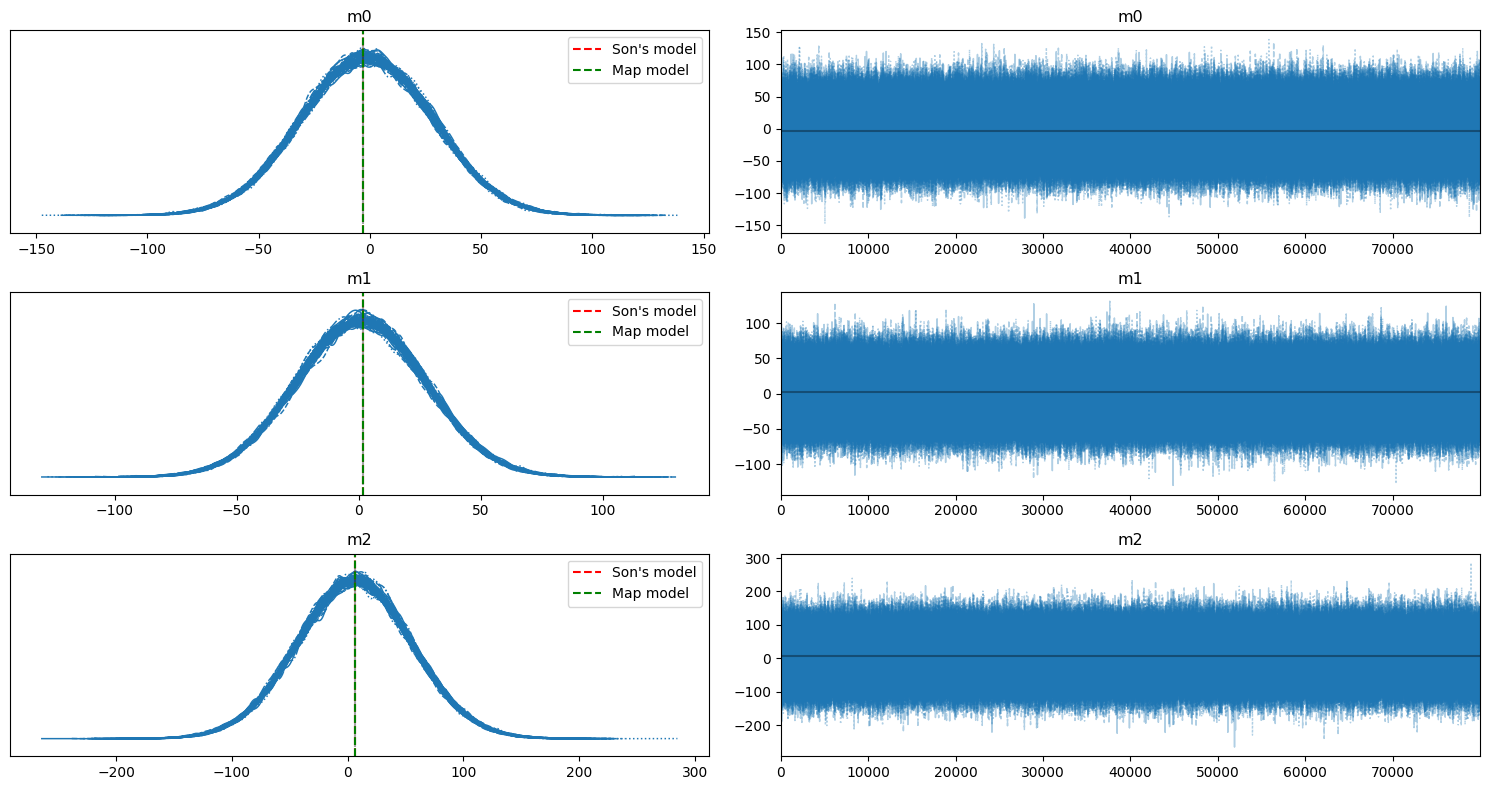

In [29]:
labels = ["m0", "m1", "m2"]

new_labels = {"var_0": "m0", "var_1": "m1", "var_2": "m2"} # Create a dictionary to map old names to new names

az_idata = az_idata_SF.rename(name_dict=new_labels) # Rename the variables in your InferenceData object

fig, ax = plt.subplots(len(mu_SF), 2, figsize=(15, 8))
az.plot_trace(az_idata,
             lines=[
        ("m0", {}, mu_SF[0]),  # 
        ("m1", {}, mu_SF[1]),  #
        ("m2", {}, mu_SF[2]),  #
    ], axes=ax);

ax[0, 0].axvline(mu_SF[0], color="r", ls="--", label="Son's model")
ax[0, 0].legend(loc="upper right") # Add the legend to the plot
ax[1, 0].axvline(mu_SF[1], color="r", ls="--", label="Son's model")
ax[1, 0].legend(loc="upper right") # Add the legend to the plot
ax[2, 0].axvline(mu_SF[2], color="r", ls="--", label="Son's model")
ax[2, 0].legend(loc="upper right") # Add the legend to the plot
ax[0, 0].axvline(map_model_SF[0], color="g", ls="--", label="Map model")
ax[0, 0].legend(loc="upper right") # Add the legend to the plot
ax[1, 0].axvline(map_model_SF[1], color="g", ls="--", label="Map model")
ax[1, 0].legend(loc="upper right") # Add the legend to the plot
ax[2, 0].axvline(map_model_SF[2], color="g", ls="--", label="Map model")
ax[2, 0].legend(loc="upper right") # Add the legend to the plot

fig.tight_layout()
plt.show()

In [30]:
tau = sampler_SF.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [39.2669108  39.67088607 39.99760568]


c:\Users\thele\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:95: UserWarning: Argument reference_values does not include reference value for: m2, m0, m1
  warnings.warn(


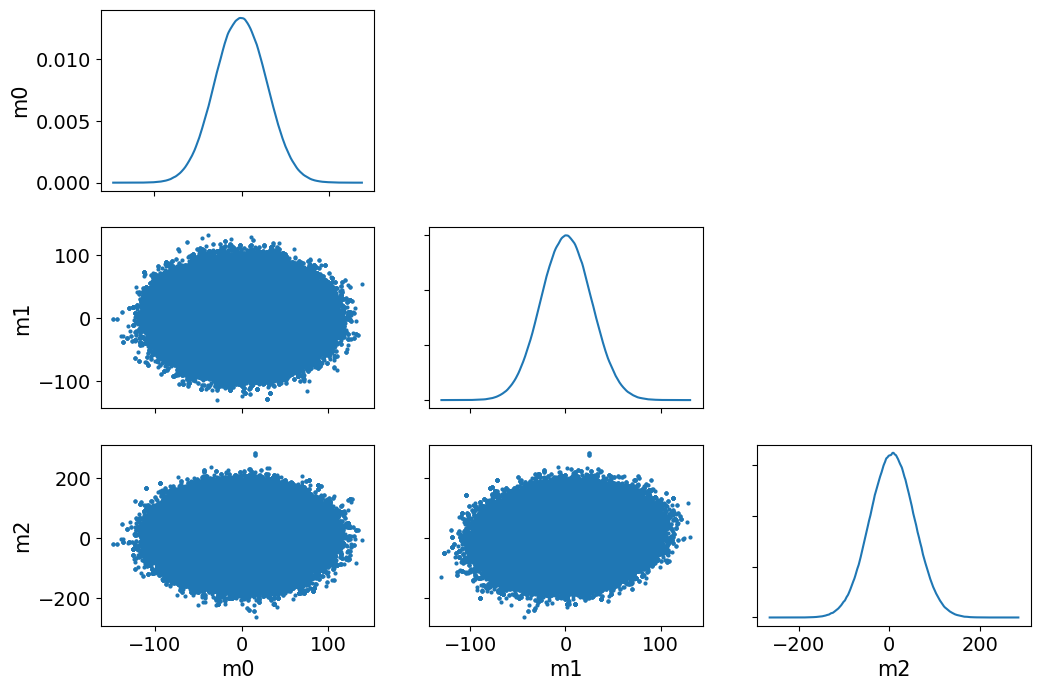

In [31]:
_m_true = np.array([0, 3, 0])

_, axes = plt.subplots(3, 3, figsize=(12,8))
az.plot_pair(
    az_idata.sel(draw=slice(300,None)), 
    marginals=True, 
    reference_values=dict(zip([f"var_{i}" for i in range(3)], _m_true.tolist())),
    ax = axes,
);

In [32]:
flat_samples = sampler_SF.get_chain(discard=300, thin=30, flat=True)

SF_opt = []

solmed = np.zeros(3)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    solmed[i] = mcmc[1]
    SF_opt.append(mcmc[1])
    q = np.diff(mcmc)
    # txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}} "
    # txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    # display(Math(txt))
    print(f"{labels[i]} = {round(mcmc[1],3)}, (-{round(q[0],3)}, +{round(q[1],3)})")

m0 = -1.149, (-29.415, +29.356)
m1 = 0.831, (-26.154, +26.318)
m2 = 5.761, (-49.333, +49.258)


In [33]:
SF_opt_max = np.array(inv_SF_results.sampler.flatchain[max_arg_SF])
SF_force_optmax = (SF_opt_max)*scaling_SF
SF_optimised_signalsmax = []
for i in range(len(stations)):
    SF_optimised_z = SF_opt_max[0]*SF_e1[i][0] + SF_opt_max[1]*SF_e2[i][0] + SF_opt_max[2]*SF_e3[i][0]
    SF_optimised_n = SF_opt_max[0]*SF_e1[i][1] + SF_opt_max[1]*SF_e2[i][1] + SF_opt_max[2]*SF_e3[i][1]
    SF_optimised_e = SF_opt_max[0]*SF_e1[i][2] + SF_opt_max[1]*SF_e2[i][2] + SF_opt_max[2]*SF_e3[i][2]
    SF_optimised_signalsmax.append([SF_optimised_z, SF_optimised_n, SF_optimised_e])

In [34]:
SF_force_opt_MAP = SF_force_optmax
print(SF_force_opt_MAP)

SF_force_az_MAP = 180 - np.arctan(SF_force_opt_MAP[2] / SF_force_opt_MAP[1])
print(SF_force_az_MAP)

sliprate = stf_tsai2007(source_duration=15, deltat=coche.dt)
CSFamp = np.max(np.cumsum(np.cumsum(sliprate)) * coche.dt**2 * np.sqrt(np.sum(SF_force_opt_MAP**2)))
txt = f"CSF amp: {CSFamp/1e11:.1f}" + "$10^{11}$ kg-m"
print(txt)  

opt_posterior = log_posterior_SF(SF_opt_max)
opt_likelihood = log_likelihood_SF(SF_opt_max)
print(f'Optimised model:   {SF_opt_max[0]:.3f}, {SF_opt_max[1]:.3f}, {SF_opt_max[2]:.3f}   LL: {log_likelihood_SF(SF_opt_max):.3f}   log-prior: {log_prior_SF(SF_opt_max):.3f}   log-p: {opt_posterior:.3f}')


[-3.26374422e+09  1.82536539e+09  5.92843673e+08]
179.68596635187174
CSF amp: 2.7$10^{11}$ kg-m
Optimised model:   -3.264, 1.825, 5.928   LL: -0.001   log-prior: -14.493   log-p: -14.493


In [35]:
test_checker_x = np.linspace(-150, 100, 250)


In [36]:
nwalkers = 64
ndim = 6
nsteps = 80000
walkers_start = np.array(mu_MT) + 0.1 * np.random.randn(nwalkers, ndim)

In [37]:
inv_problem_MT = BaseProblem()
inv_problem_MT.set_log_posterior(log_posterior_MT)
inv_problem_MT.set_model_shape(ndim)
inv_problem_MT.set_data(ydatas)
inv_options_MT = InversionOptions()
inv_options_MT.set_tool('emcee')
inv_options_MT.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start)

In [38]:
inv_MT = Inversion(inv_problem_MT, inv_options_MT)
inv_MT_results = inv_MT.run()

######## Check result
print(f"The inversion MT result from `emcee`:")
inv_MT_results.summary()

The inversion MT result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: None


In [39]:
# calculate fits of selected models
min_arg_MT = np.argmin(inv_MT_results.sampler.flatlnprobability)
lp_min_MT = inv_MT_results.sampler.flatlnprobability[min_arg_MT]
bad_model_MT = inv_MT_results.sampler.flatchain[min_arg_MT]
max_arg_MT = np.argmax(inv_MT_results.sampler.flatlnprobability)
lp_max_MT = inv_MT_results.sampler.flatlnprobability[max_arg_MT]
map_model_MT = inv_MT_results.sampler.flatchain[max_arg_MT]

In [40]:
# print out table of fits for selected models
print(f'Map model:   {map_model_MT[0]:.3f}, {map_model_MT[1]:.3f}, {map_model_MT[2]:.3f}   LL: {log_likelihood_MT(map_model_MT):.3f}   log-prior: {log_prior_MT(map_model_MT):.3f}   log-p: {lp_max_MT:.3f}   index: {max_arg_MT}')
print(f'Bad model:   {bad_model_MT[0]:.3f}, {bad_model_MT[1]:.3f}, {bad_model_MT[2]:.3f}  LL: {log_likelihood_MT(bad_model_MT):.3f}   log-prior: {log_prior_MT(bad_model_MT):.3f}  log-p: {lp_min_MT:.3f}   index: {min_arg_MT}')

Map model:   24.957, -25.052, -20.060   LL: -0.002   log-prior: -28.986   log-p: -28.987   index: 172
Bad model:   -146.958, -116.779, -148.746  LL: -0.177   log-prior: -49.078  log-p: -49.255   index: 2541701


In [41]:
sampler_MT = inv_MT_results.sampler
az_idata_MT = inv_MT_results.to_arviz()

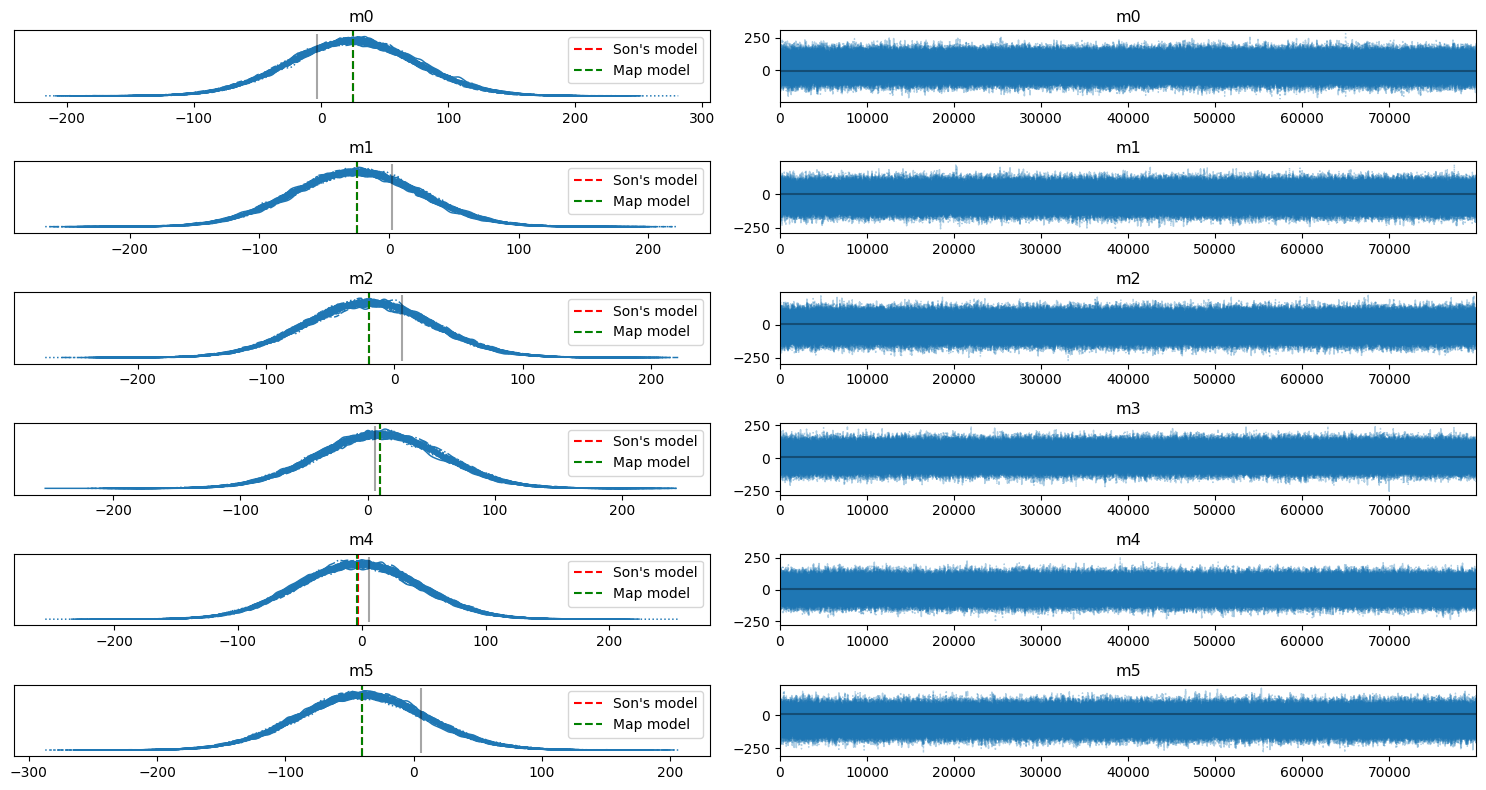

In [42]:
labels = ["m0", "m1", "m2", "m3", "m4", "m5"]

new_labels = {"var_0": "m0", "var_1": "m1", "var_2": "m2", "var_3": "m3", "var_4": "m4", "var_5": "m5"} # Create a dictionary to map old names to new names

az_idata = az_idata_MT.rename(name_dict=new_labels) # Rename the variables in your InferenceData object

fig, ax = plt.subplots(len(mu_MT), 2, figsize=(15, 8))
az.plot_trace(az_idata,
             lines=[
        ("m0", {}, mu_SF[0]),  # 
        ("m1", {}, mu_SF[1]),  #
        ("m2", {}, mu_SF[2]),  #
        ("m3", {}, mu_SF[2]),  #
        ("m4", {}, mu_SF[2]),  #
        ("m5", {}, mu_SF[2]),  #
    ], axes=ax);

ax[0, 0].axvline(mu_MT[0], color="r", ls="--", label="Son's model")
ax[0, 0].legend(loc="upper right") # Add the legend to the plot
ax[1, 0].axvline(mu_MT[1], color="r", ls="--", label="Son's model")
ax[1, 0].legend(loc="upper right") # Add the legend to the plot
ax[2, 0].axvline(mu_MT[2], color="r", ls="--", label="Son's model")
ax[2, 0].legend(loc="upper right") # Add the legend to the plot
ax[3, 0].axvline(mu_MT[3], color="r", ls="--", label="Son's model")
ax[3, 0].legend(loc="upper right") # Add the legend to the plot
ax[4, 0].axvline(mu_MT[4], color="r", ls="--", label="Son's model")
ax[4, 0].legend(loc="upper right") # Add the legend to the plot
ax[5, 0].axvline(mu_MT[5], color="r", ls="--", label="Son's model")
ax[5, 0].legend(loc="upper right") # Add the legend to the plot
ax[0, 0].axvline(map_model_MT[0], color="g", ls="--", label="Map model")
ax[0, 0].legend(loc="upper right") # Add the legend to the plot
ax[1, 0].axvline(map_model_MT[1], color="g", ls="--", label="Map model")
ax[1, 0].legend(loc="upper right") # Add the legend to the plot
ax[2, 0].axvline(map_model_MT[2], color="g", ls="--", label="Map model")
ax[2, 0].legend(loc="upper right") # Add the legend to the plot
ax[3, 0].axvline(map_model_MT[3], color="g", ls="--", label="Map model")
ax[3, 0].legend(loc="upper right") # Add the legend to the plot
ax[4, 0].axvline(map_model_MT[4], color="g", ls="--", label="Map model")
ax[4, 0].legend(loc="upper right") # Add the legend to the plot
ax[5, 0].axvline(map_model_MT[5], color="g", ls="--", label="Map model")
ax[5, 0].legend(loc="upper right") # Add the legend to the plot

fig.tight_layout()
plt.show()

In [43]:
tau = sampler_MT.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [68.341145   69.45685974 68.59585146 68.37530373 68.15922441 67.94009957]


c:\Users\thele\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:95: UserWarning: Argument reference_values does not include reference value for: m4, m0, m1, m3, m2, m5
  warnings.warn(


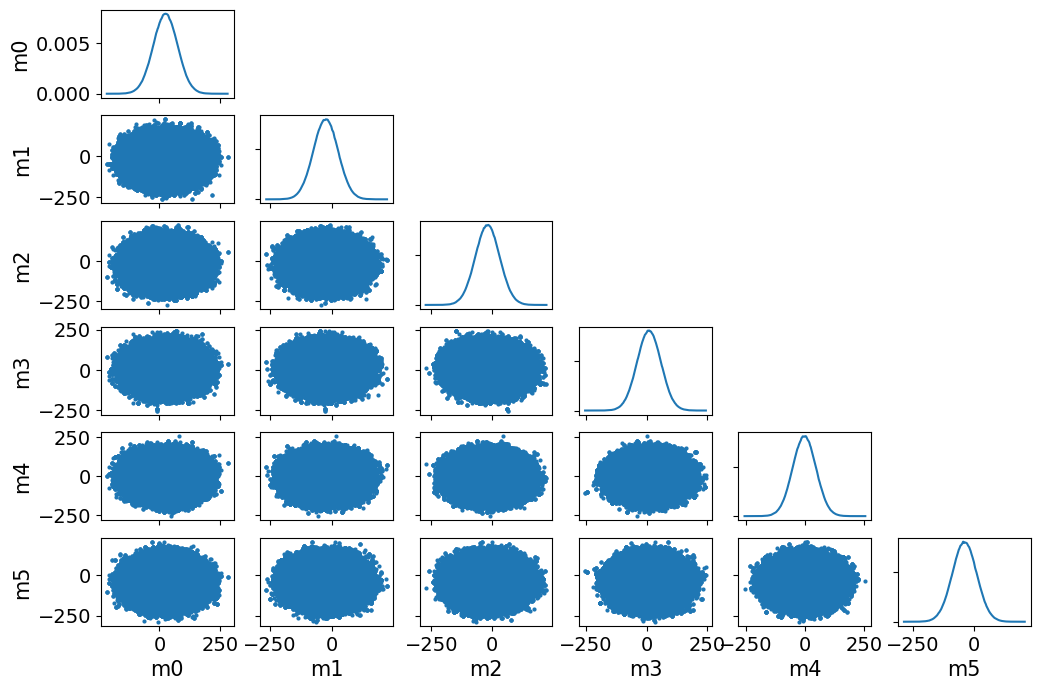

In [44]:
_m_true = np.array([0, 6, 0])

_, axes = plt.subplots(6, 6, figsize=(12,8))
az.plot_pair(
    az_idata.sel(draw=slice(300,None)), 
    marginals=True, 
    reference_values=dict(zip([f"var_{i}" for i in range(6)], _m_true.tolist())),
    ax = axes,
);

In [45]:
flat_samples = sampler_MT.get_chain(discard=300, thin=30, flat=True)

MT_opt = []

solmed = np.zeros(6)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    solmed[i] = mcmc[1]
    MT_opt.append(mcmc[1])
    q = np.diff(mcmc)
    # txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}} "
    # txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    # display(Math(txt))
    print(f"{labels[i]} = {round(mcmc[1],3)}, (-{round(q[0],3)}, +{round(q[1],3)})")

m0 = 24.787, (-49.951, +49.922)
m1 = -25.258, (-49.681, +49.667)
m2 = -20.112, (-49.508, +49.571)
m3 = 9.287, (-48.88, +48.903)
m4 = -2.994, (-48.952, +49.085)
m5 = -40.248, (-49.749, +49.49)


In [46]:
MT_opt_max = np.array(inv_MT_results.sampler.flatchain[max_arg_MT])
MT_force_optmax = (MT_opt_max)*scaling_MT
MT_optimised_signalsmax = []
for i in range(len(stations)):
    MT_optimised_z = MT_opt_max[0]*MT_e1[i][0] + MT_opt_max[1]*MT_e2[i][0] + MT_opt_max[2]*MT_e3[i][0]
    MT_optimised_n = MT_opt_max[0]*MT_e1[i][1] + MT_opt_max[1]*MT_e2[i][1] + MT_opt_max[2]*MT_e3[i][1]
    MT_optimised_e = MT_opt_max[0]*MT_e1[i][2] + MT_opt_max[1]*MT_e2[i][2] + MT_opt_max[2]*MT_e3[i][2]
    MT_optimised_signalsmax.append([MT_optimised_z, MT_optimised_n, MT_optimised_e])

In [47]:
MT_force_opt_MAP = MT_force_optmax
print(MT_force_opt_MAP)


opt_posterior = log_posterior_MT(MT_opt_max)
opt_likelihood = log_likelihood_MT(MT_opt_max)
print(f'Optimised model:   {MT_opt_max[0]:.3f}, {MT_opt_max[1]:.3f}, {MT_opt_max[2]:.3f}, {MT_opt_max[3]:.3f}, {MT_opt_max[4]:.3f}, {MT_opt_max[5]:.3f}\n LL: {log_likelihood_MT(MT_opt_max):.3f}   log-prior: {log_prior_MT(MT_opt_max):.3f}   log-p: {opt_posterior:.3f}')

[ 2.49568925e+14 -2.50524685e+14 -2.00601909e+14  9.70970252e+15
 -3.42820057e+15 -4.01963435e+14]
Optimised model:   24.957, -25.052, -20.060, 9.710, -3.428, -40.196
 LL: -0.002   log-prior: -28.986   log-p: -28.987


In [48]:
SF_force_opt_MAP = SF_force_optmax
print(SF_force_opt_MAP)

SF_force_az_MAP = 180 - np.arctan(SF_force_opt_MAP[2] / SF_force_opt_MAP[1])
print(SF_force_az_MAP)

sliprate = stf_tsai2007(source_duration=15, deltat=coche.dt)
CSFamp = np.max(np.cumsum(np.cumsum(sliprate)) * coche.dt**2 * np.sqrt(np.sum(SF_force_opt_MAP**2)))
txt = f"CSF amp: {CSFamp/1e11:.1f}" + "$10^{11}$ kg-m"
print(txt)  

opt_posterior = log_posterior_SF(SF_opt_max)
opt_likelihood = log_likelihood_SF(SF_opt_max)
print(f'Optimised model:   {SF_opt_max[0]:.3f}, {SF_opt_max[1]:.3f}, {SF_opt_max[2]:.3f}   LL: {log_likelihood_SF(SF_opt_max):.3f}   log-prior: {log_prior_SF(SF_opt_max):.3f}   log-p: {opt_posterior:.3f}')

[-3.26374422e+09  1.82536539e+09  5.92843673e+08]
179.68596635187174
CSF amp: 2.7$10^{11}$ kg-m
Optimised model:   -3.264, 1.825, 5.928   LL: -0.001   log-prior: -14.493   log-p: -14.493


In [49]:
print('Residual Statistics SF MAP model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_sf = []
residualss_sf = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_sf, model_r_sf, model_t_sf = SF_optimised_signalsmax[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_sf, model_r_sf, model_t_sf))
    residuals_sf, tshifts_sf = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' SF MAP offsets detected ', tshifts_sf)
    aligned_sf = np.zeros_like(d_model)
    for j in range(3): aligned_sf[j] = np.roll(d_model[j], -tshifts_sf[j])
    model_z_sf, model_r_sf, model_t_sf = aligned_sf

    model_sf.append([model_z_sf, model_r_sf, model_t_sf])

    res_sf_z = data_z - model_z_sf
    res_sf_r = data_r - model_r_sf
    res_sf_t = data_t - model_t_sf

    residualss_sf.append([res_sf_z, res_sf_r, res_sf_t])

    rms_sf_z = np.sqrt(np.mean(res_sf_z**2))
    rms_sf_r = np.sqrt(np.mean(res_sf_r**2))
    rms_sf_t = np.sqrt(np.mean(res_sf_t**2))
    rmss_z.append(rms_sf_z)
    rmss_r.append(rms_sf_r)
    rmss_t.append(rms_sf_t)

    print(f'  Station {stations[i]} SF MAP RMS Z: {rms_sf_z:.3e}, R: {rms_sf_r:.3e}, T: {rms_sf_t:.3e}')
    

print('=' * 50)
print(f'Overall SF MAP RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print(f'overall RMS (all components): {(np.abs(np.mean(rmss_z)) + np.abs(np.mean(rmss_r)) + np.abs(np.mean(rmss_t)))/3:.3e}')
print('--------------------------------------------')

print('Residual Statistics MT MAP model: ')
print('=' * 50)

rmss_z, rmss_r, rmss_t = [], [], []

model_mt = []
residualss_mt = []

for i in range(len(stations)):
    data_z, data_r, data_t = ydatas[i][:,0], ydatas[i][:,1], ydatas[i][:,2]
    model_z_mt, model_r_mt, model_t_mt = MT_optimised_signalsmax[i]
    d_obs = np.vstack((data_z, data_r, data_t))
    d_model = np.vstack((model_z_mt, model_r_mt, model_t_mt))
    residuals_mt, tshifts_mt = station_residual(d_obs, d_model, max_shift=50, shifts_per_station=3, return_tshift=True)
    print(' Station ', i, ' MT MAP offsets detected ', tshifts_mt)
    aligned_MT = np.zeros_like(d_model)
    for j in range(3): aligned_MT[j] = np.roll(d_model[j], -tshifts_mt[j])
    model_z_mt, model_r_mt, model_t_mt = aligned_MT

    model_mt.append([model_z_mt, model_r_mt, model_t_mt])

    res_mt_z = data_z - model_z_mt
    res_mt_r = data_r - model_r_mt
    res_mt_t = data_t - model_t_mt

    residualss_mt.append([res_mt_z, res_mt_r, res_mt_t])

    rms_mt_z = np.sqrt(np.mean(res_mt_z**2))
    rms_mt_r = np.sqrt(np.mean(res_mt_r**2))
    rms_mt_t = np.sqrt(np.mean(res_mt_t**2))
    rmss_z.append(rms_mt_z)
    rmss_r.append(rms_mt_r)
    rmss_t.append(rms_mt_t)

    print(f'  Station {stations[i]} MT MAP RMS Z: {rms_mt_z:.3e}, R: {rms_mt_r:.3e}, T: {rms_mt_t:.3e}')

print('=' * 50)
print(f'Overall MT MAP RMS Z: {np.mean(rmss_z):.3e}, R: {np.mean(rmss_r):.3e}, T: {np.mean(rmss_t):.3e}')
print(f'overall RMS (all components): {(np.abs(np.mean(rmss_z)) + np.abs(np.mean(rmss_r)) + np.abs(np.mean(rmss_t)))/3:.3e}')

Residual Statistics SF MAP model: 
 Station  0  SF MAP offsets detected  [np.int64(-1), np.int64(-2), np.int64(22)]
  Station UNGL SF MAP RMS Z: 1.278e-08, R: 1.134e-08, T: 1.953e-08
Overall SF MAP RMS Z: 1.278e-08, R: 1.134e-08, T: 1.953e-08
overall RMS (all components): 1.455e-08
--------------------------------------------
Residual Statistics MT MAP model: 
 Station  0  MT MAP offsets detected  [np.int64(-3), np.int64(-3), np.int64(5)]
  Station UNGL MT MAP RMS Z: 3.702e-08, R: 3.191e-08, T: 2.838e-08
Overall MT MAP RMS Z: 3.702e-08, R: 3.191e-08, T: 2.838e-08
overall RMS (all components): 3.244e-08


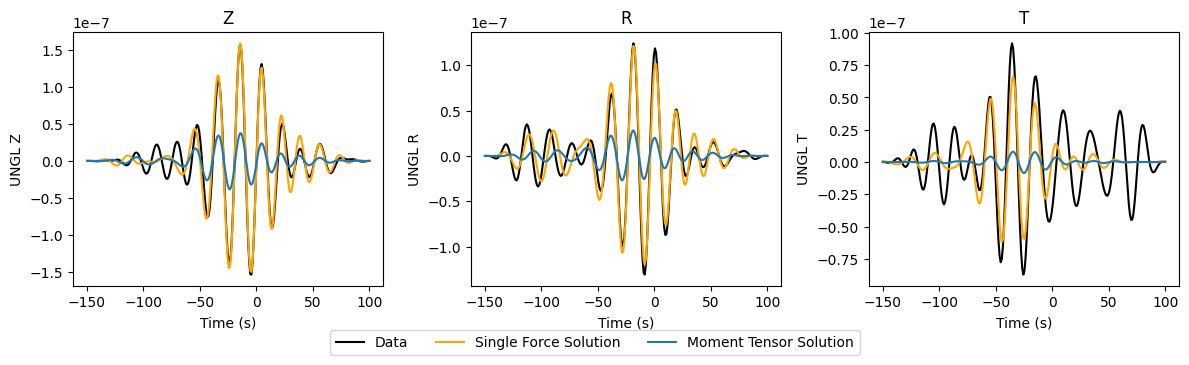

In [50]:
n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True)

for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, ydatas[0][:, j], c='k', label=f'Data')
        #ax.plot(test_checker_x, SF_optimised_signals[0][j], c='b', label='SF Optimised')
        # ax.plot(test_checker_x, SF_optimised_signalsmin[0][j], c='g', label='SF Opt Min') # <<the opposite to MAP
        #ax.plot(test_checker_x, SF_optimised_signalsmax[0][j], c='m', label='SF Opt Max') # << the MAP
        # ax.plot(test_checker_x, SF_son_signals[0][j], c='r', label='SF Son et al. 2025')
        ax.plot(test_checker_x, model_sf[0][j], c='orange', label='Single Force Solution')
        # ax.plot(test_checker_x, SF_optimised_signals_v1[i][j], c='r', label='SF Optimised V1')
        ax.plot(test_checker_x, model_mt[0][j], c='tab:blue', label='Moment Tensor Solution')
        ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_title(comp)
        # ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
# plt.suptitle('Observed vs Son-model predictions', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

fig.savefig('FD_realistic_waves.svg', bbox_inches='tight')

plt.show()

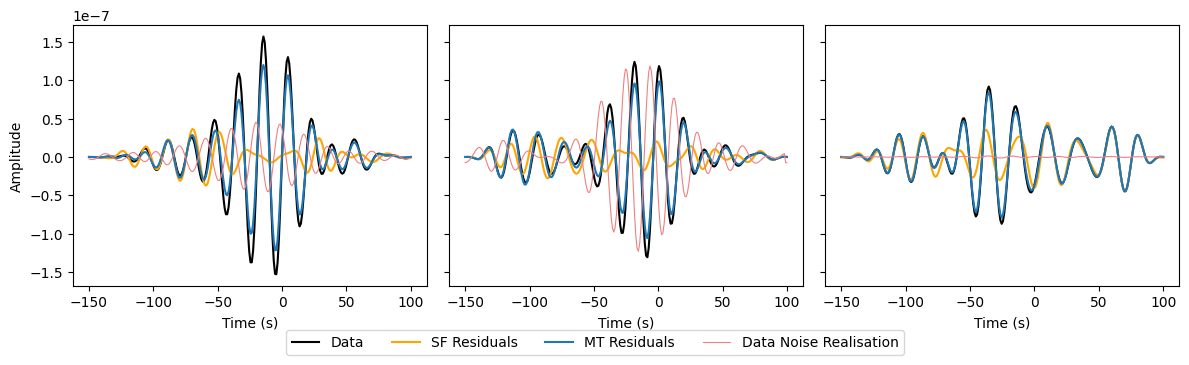

In [51]:
n_stations = len(stations)
fig_height = 3.5 * n_stations  # Adjust scaling as needed
fig, axes = plt.subplots(n_stations, 3, figsize=(12, fig_height), sharex=True, sharey=True)

cdset = [C_ddz, C_ddr, C_ddt]


for i in range(n_stations):
    for j, comp in enumerate(['Z', 'R', 'T']):
        ax = axes[j]
        ax.plot(test_checker_x, ydatas[0][:, j], c='k', label=f'Data')
        #ax.plot(test_checker_x, SF_optimised_signals[0][j], c='b', label='SF Optimised')
        # ax.plot(test_checker_x, SF_optimised_signalsmin[0][j], c='g', label='SF Opt Min') # <<the opposite to MAP
        #ax.plot(test_checker_x, SF_optimised_signalsmax[0][j], c='m', label='SF Opt Max') # << the MAP
        # ax.plot(test_checker_x, SF_son_signals[0][j], c='r', label='SF Son et al. 2025')
        ax.plot(test_checker_x, residualss_sf[i][j], c='orange', label='SF Residuals')
        ax.plot(test_checker_x, residualss_mt[i][j], c='tab:blue', label='MT Residuals')
        ax.plot(test_checker_x,np.random.multivariate_normal(np.zeros(250),cdset[j]),c='lightcoral', lw=0.8, label='Data Noise Realisation')

        if j == 0:
            ax.set_ylabel(f'Amplitude')

        # ax.set_ylabel(f'{stations[i]} {comp}')
        if i == n_stations - 1:
            ax.set_xlabel('Time (s)')
        # if i == 0:
        #     ax.set_title(comp)
        # ax.grid(True)
        #ax.legend(loc='upper right', fontsize=8)
# plt.suptitle('Observed vs Son-model predictions', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()

# Add legend underneath the figure with 3 columns
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

fig.savefig('FD_realistic_residuals.svg', bbox_inches='tight')
plt.show()